In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import joblib
import math
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from data_loading import create_xarr, mad, create_label_df
from utils import DateIter
from threshold_edge_detection import lowess_smooth, measure_thresholds
from IPython.display import clear_output

In [8]:
# parent_dir     = 'raw_data'
parent_dir     = 'data_files'

label_csv_path = 'official_labels.csv'
data_out_path  = 'processed_data/full_data.joblib'
label_out_path = 'labels/labels.joblib'

In [3]:
full_xarr = create_xarr(
    parent_dir=parent_dir,
    expected_shape=(720, 300),
    dtype=(np.uint16, np.float32),
    apply_fn=mad,
    plot=False,
)

label_df = create_label_df(
    csv_path=label_csv_path,
)

In [4]:
label_df

,binary_label,xmin,xmax,ymin,ymax,period
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-12-27,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-28,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-29,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
joblib.dump(full_xarr, data_out_path)
joblib.dump(label_df, label_out_path)

# %pip install netCDF4
# full_xarr.to_netcdf('full_data.nc')

['labels/labels.joblib']

In [12]:
date_iter = DateIter(data_out_path) #, label_df=label_out_path)

In [13]:
def save_wrap(save_dir, fmt='%Y-%m-%d', ext='.png', **kwargs):
    os.makedirs(save_dir, exist_ok=True)
    def wrapped(date):
        date_str = pd.to_datetime(date).strftime(fmt)
        file_path = os.path.join(save_dir, date_str + ext)
        plt.savefig(file_path, **kwargs)
        return
    return wrapped

In [64]:
def run_edge_detect(
    dates,
    x_trim=.08333,
    y_trim=.08,
    sigma=4.2, # 3.8 was good # Gaussian filter kernel
    qs=[.4, .5, .6],
    occurence_n = 60,
    i_max=30,
    plot=True,
    clear_every=100,
    plt_save_path=None,
    csv_save_path=None,
    thresh=None,
):
    processed_dates = list()
    if plt_save_path is not None:
        save_plt = save_wrap(plt_save_path)
    else:
        save_plt = None
        
#     final_edge_dict = dict()
    final_edge_list = list()
    if dates == 'all':
        date_gen = date_iter.iter_all()
    else:
        date_gen = date_iter.iter_dates(dates, raise_missing=False)

    for i, (date, arr) in enumerate(date_gen):
        if arr is None:
            warnings.warn(f'Date {date} has no input')
            continue
            
        if not i % clear_every:
            clear_output()

        xl_trim, xr_trim = x_trim if isinstance(x_trim, (tuple, list)) else (x_trim, x_trim)
        yl_trim, yr_trim = x_trim if isinstance(y_trim, (tuple, list)) else (y_trim, y_trim)
        xr, xl = math.floor(xl_trim * arr.shape[0]), math.floor(xr_trim * arr.shape[0])
        yr, yl = math.floor(yl_trim * arr.shape[1]), math.floor(yr_trim * arr.shape[1])

        arr = arr[xr:-xl, yr:-yl]

        heights = arr.coords['height']
        times = arr.coords['time'] # .to_pandas().dt.strftime('%H:%M')

        arr_xr = arr
        arr = np.nan_to_num(arr, nan=0)

        arr = gaussian_filter(arr.T, sigma=(sigma, sigma))  # [::-1,:]
        med_lines, min_line, minz_line = measure_thresholds(
            arr, # [::-1]
            qs=qs, 
            occurrence_n=occurence_n, 
            i_max=i_max
        )

        data = pd.DataFrame(
            np.array(med_lines).T,
            index=(date + times).dt.strftime('%H:%M'),
            columns=qs,
        ).reset_index(
            names='Time',
        )
        
        
        if thresh is None:
            edge_line = pd.DataFrame(
                min_line, 
                index=(date + times).dt.strftime('%H:%M'), 
                columns=['Height'],
            ).reset_index(
                names='Time'
            )
        elif isinstance(thresh, dict):
            edge_line = (
                data[['Time', thresh[date]]]
                .rename(columns={thresh[date] : 'Height'})
            )
        elif isinstance(thresh, float):
            edge_line = (
                data[['Time', thresh]]
                .rename(columns={thresh : 'Height'})
            )
        else:
            raise ValueError(f'Threshold {thresh} of type {type(thresh)} is invalid')

#         final_edge_dict[date] = min_line.squeeze()
        final_edge_list.append(
            pd.Series(min_line.squeeze(), index=times, name=date)
        )

        if plot or save_plt is not None:
            fig, ax = plt.subplots(1, 1, figsize=(15,8))
            plt.title(f'| {date} |')
            sns.heatmap(
                pd.DataFrame(
                    arr, # [::-1],
                    index=heights,
                    columns=times,
                ), 
                robust=True, 
                cbar=False, 
                ax=ax,
            )
            ax.invert_yaxis()

            sns.lineplot(
                data=data, 
                alpha=.75, 
                dashes=False, 
                ax=ax, 
                palette='light:b',
            )
            sns.lineplot(
                data=edge_line, 
                x='Time', 
                y='Height', 
                color='white', 
                alpha=1, 
                dashes=False, 
                ax=ax,
            )

            if save_plt is not None:
                save_plt(date)
            
            processed_dates.append(date)
            plt.show() if plot else plt.clear()
                
#     final_edge_df = pd.DataFrame(
#         final_edge_dict, 
#         index=list(range(60,660,1))
#     )
    final_edge_df = pd.concat(final_edge_list, axis=1)
    if csv_save_path:
        final_edge_df.to_csv(csv_save_path)
    
    return {'date':date,'arr':arr,'arr_xr':arr_xr,'final_edge_df':final_edge_df,'data':data,'edge_line':edge_line}

/Users/r01344106/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/r01344106/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/r01344106/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/r01344106/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

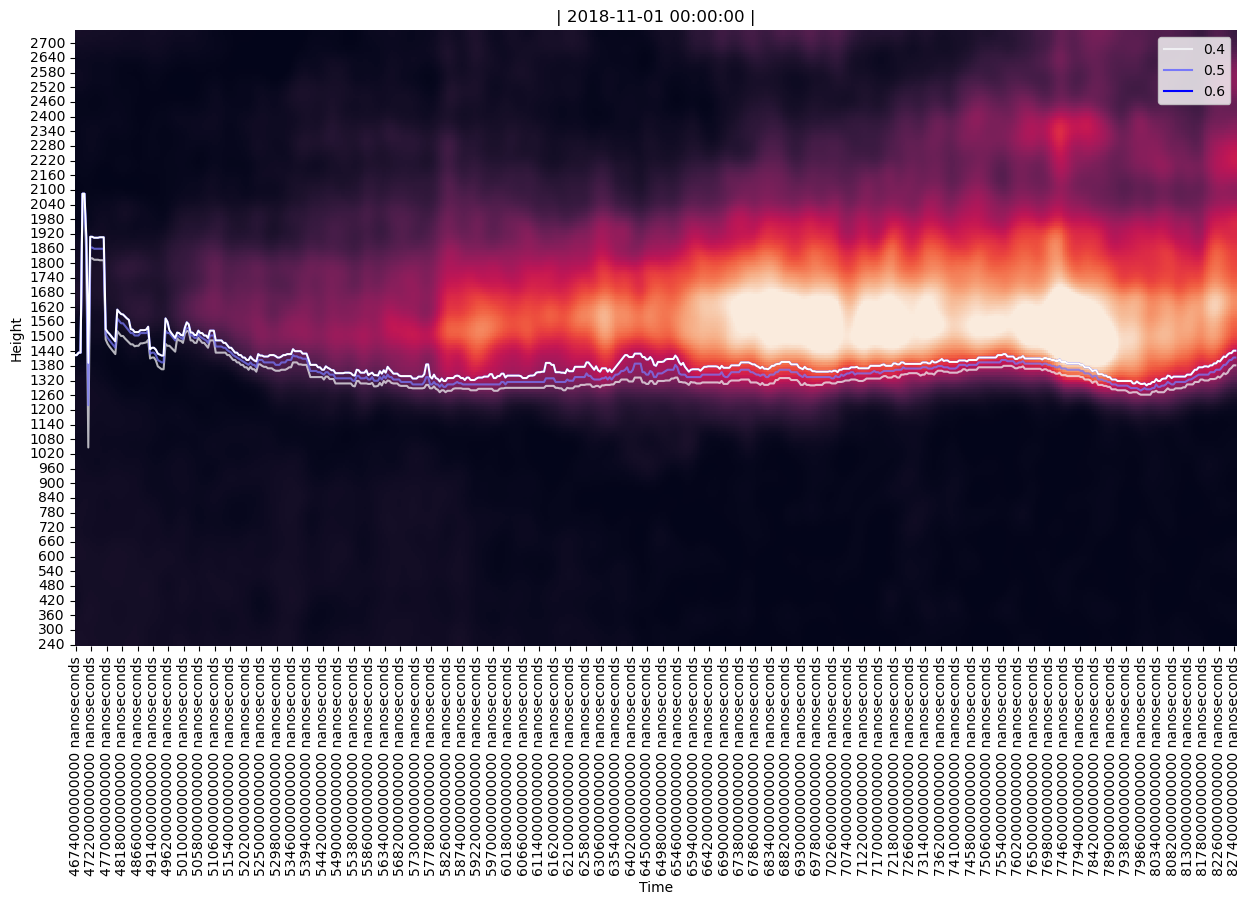

In [65]:
result = run_edge_detect(
    [('2018-11-1','2018-11-1')], 
    csv_save_path=None,
    plot=True,
    plt_save_path='output'
)

In [66]:
date          = result['date']
data          = result['data']
edge_line     = result['edge_line']

arr           = result['arr']
arr_xr        = result['arr_xr']
final_edge_df = result['final_edge_df']


heights = arr_xr.coords['height']
# times   = arr_xr.coords['time']#.to_pandas().dt.strftime('%H:%M')

times   = arr_xr.coords['time'].to_pandas()

In [61]:
pd.Timestamp(arr_xr['date'].values)

Timestamp('2018-11-01 00:00:00')

In [52]:
# pd.Timestamp(times)
times.iloc[0]

Timedelta('0 days 12:59:00')

/Users/r01344106/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/r01344106/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/r01344106/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/r01344106/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

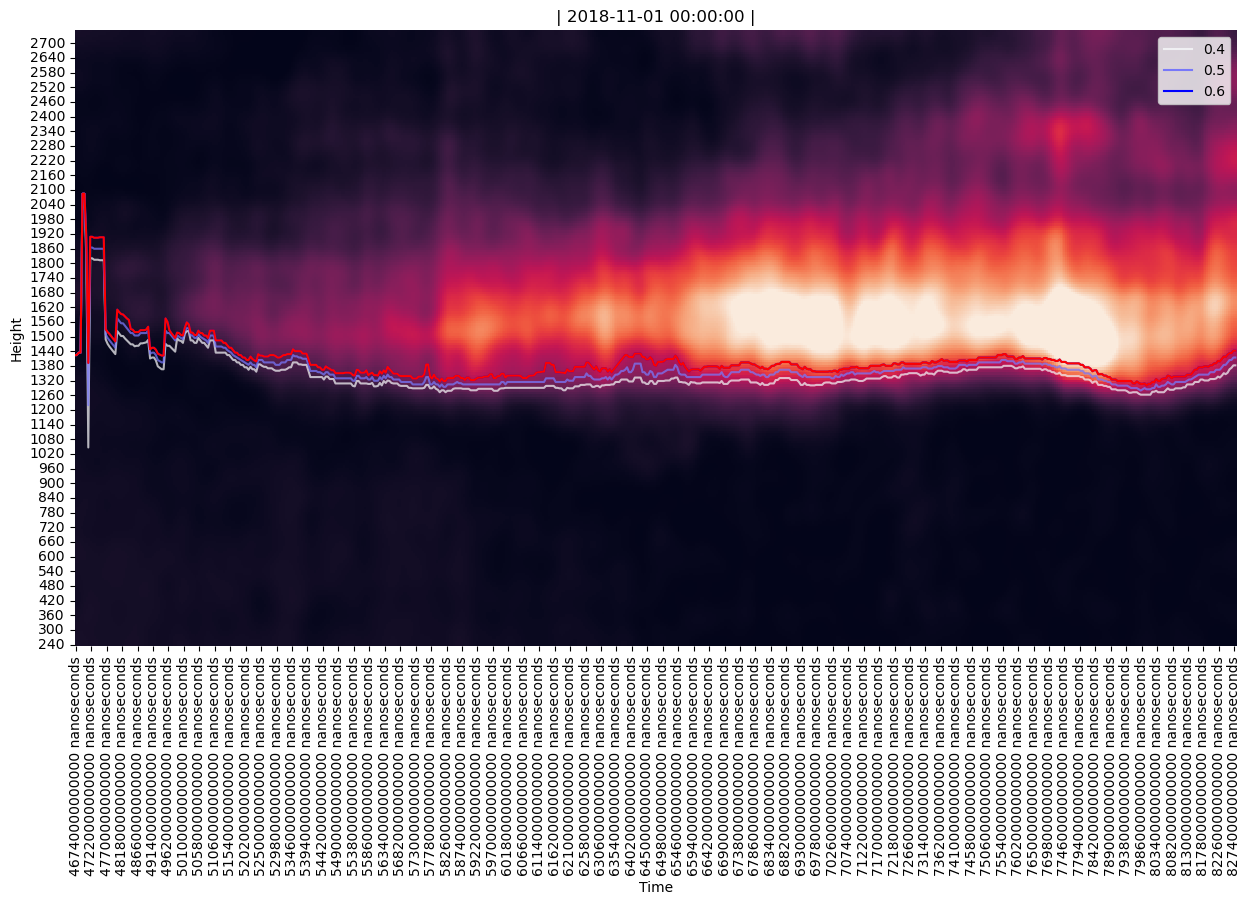

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
plt.title(f'| {date} |')

sns.heatmap(
    pd.DataFrame(
        arr, # [::-1],
        index=heights,
        columns=times,
    ), 
    robust=True, 
    cbar=False, 
    ax=ax,
)
ax.invert_yaxis()

sns.lineplot(
    data=data, 
    alpha=.75, 
    dashes=False, 
    ax=ax, 
    palette='light:b',
)

sns.lineplot(
    data=edge_line, 
    x='Time', 
    y='Height', 
    color='red', 
    alpha=1, 
    dashes=False, 
    ax=ax,
)

plt.show()